In [ ]:
!nvidia-smi

Tue Nov 23 12:39:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

sample_data  tale2.txt


In [1]:
!pip install transformers
!pip install fastai==2.2.5

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
     |████████████████████████████████| 61 kB 328 kB/s 
     |████████████████████████████████| 3.3 MB 19.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 191 kB 5.3 MB/s 
     |████████████████████████████████| 776.8 MB 19 kB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 12.8 MB 12.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstall

In [2]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.7.1
4.12.5
2.2.5


In [39]:
#download model and tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:698: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [48]:
text = """ 옛날 옛날, 어느 마을에 형제가"""
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=280,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

옛날 옛날 어느 마을에 형제가 왁자지껄 떠들어대며 "우리 집엔 왜 이렇게 많은 사람들이 모여 사는 거야?" 하고 묻는다. 
그런데 그 마을 사람들은 모두 다를 자기네 동네에 살고 있는 사람들이라고 한다. 이렇게 해서 우리 마을은 '흥부가 살던 곳'이라는 뜻의 '고향'이 되었다. 
그리고 이 고향은 바로 지금의 서울 좀로구 승인동이다. 숭인동은 원래 종로에서 가장 오래된 주택가였다.
 | 1970 년대까지만 해도 이곳은 재개발로 인해 헐리고 빈집이 많아졌다. 하지만 1980 년대 들어 다시 활기를 되찾기 시작했다.


In [4]:
with open('tale4.txt') as f:
    lines = f.read()
lines=" ".join(lines.split())
len(lines)
lines=re.sub('\(계속\).*?[●○]', '', lines)
lines=re.sub('[●○]', '', lines)
len(lines)

363548

In [5]:
#model input output tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
# dls.show_batch(max_n=2)

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=2.511886486900039e-05)


epoch,train_loss,valid_loss,perplexity,time
0,1.467664,3.805481,44.946884,02:27


epoch,train_loss,valid_loss,perplexity,time
0,1.299269,1.777156,5.913019,02:27
1,0.698240,1.560367,4.760569,02:27
2,0.600757,1.673668,5.331689,02:27
3,0.464843,1.285035,3.614795,02:27
4,0.287612,0.974926,2.650972,02:26
5,0.169332,0.776226,2.173254,02:26
6,0.103067,0.641747,1.899796,02:26
7,0.050677,0.592004,1.807607,02:26


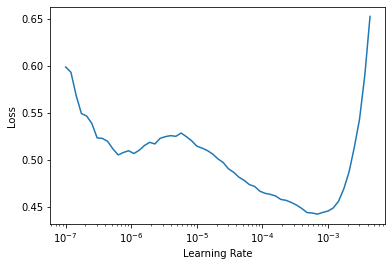

In [13]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)

learn.fine_tune(8)

In [49]:
prompt="""옛날 옛날, 어느 마을에 형제가"""
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=100,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'옛날 옛날, 어느 마을에 형제가 살았어.. 형 이름은 \'놀부\'고, 동생은 훌쩍훌려 했지. 둘은 형제였지만 수박의 겉과 속이 다르고 동전의 앞뒷면이 다른 것처럼 달라도 많이 달랐더구나." 동생이 하루아침에 부자가 됐다는 소문을 듣고 심술이 나서 견딜 수가 없었대요. 그런데 깊은 숲에 조금 늦게 봄이 왔을 거야 "아, 문을 꼭꼭 잠들었다!" 공주가 막 음식을 먹으려고 할 때였습니다. 똑똑 정중'